# Imports

In [3]:
%tensorflow_version 2.x

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow.keras import Sequential
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import shutil
import numpy as np
import PIL.Image as Image
import matplotlib.pylab as plt

#dark mode
plt.rc_context({'xtick.color':'w', 'ytick.color':'w', 'text.color':'w', 'axes.labelcolor':'w'})

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

TensorFlow 2.x selected.


In [4]:
!pip install googleimagedownloader
from googleimagedownloader.googleimagedownloader import GoogleImageDownloader

  Created wheel for requests-futures: filename=requests_futures-1.0.0-cp36-none-any.whl size=7012 sha256=5211f5e33d8862df255195a8003b15057fb48fa76e96fed6ea2a3152a2632473
  Stored in directory: /root/.cache/pip/wheels/26/d0/f5/dc4e4a37bbe55c9acf967d2bd899152412c1e49c227f5395ff
Successfully built requests-futures


# Testing an existing classifier

In [0]:
IMAGE_SIZE = (224, 224)

In [0]:
classifier_url ="https://tfhub.dev/google/imagenet/resnet_v2_50/classification/4" 

In [0]:
classifier = Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SIZE+(3,))
])

90112/86910 [===============================] - 0s 1us/step


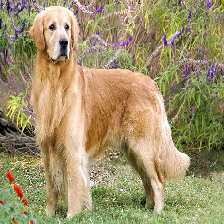

In [8]:
test_image = get_file('img.jpg','https://disenlis.com/wp-content/uploads/2019/01/Golden-Retriever-Standing1.jpg')
test_image = Image.open(test_image).resize(IMAGE_SIZE)
test_image

In [9]:
test_image = np.array(test_image)/255.0
test_image.shape

(224, 224, 3)

In [10]:
result = classifier.predict(test_image[np.newaxis, ...])
result.shape

(1, 1001)

In [11]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

208

In [12]:
labels_path = get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


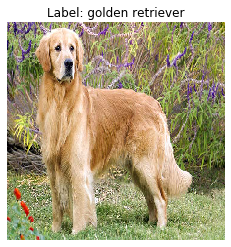

In [13]:
predicted_class_name = imagenet_labels[predicted_class]

plt.axis('off')
plt.title("Label: " + predicted_class_name, color = 'black')
plt.imshow(test_image)
plt.show()

# Transfer Learning

## Build the dataset

In [0]:
class_names = ['hulk','hawkeye']
path = 'dataset/'

train_dir = os.path.join(path, 'train')
validation_dir = os.path.join(path, 'validation')

train_ca_dir = os.path.join(train_dir, 'hulk')  
train_im_dir = os.path.join(train_dir, 'hawkeye')  
validation_ca_dir = os.path.join(validation_dir, 'hulk') 
validation_im_dir = os.path.join(validation_dir, 'hawkeye')  

if os.path.exists(path):
  shutil.rmtree(path)

os.makedirs(train_ca_dir)
os.makedirs(train_im_dir)
os.makedirs(validation_ca_dir)    
os.makedirs(validation_im_dir)

In [0]:
def manage_images(src, dest_train, dest_val, image_resize=IMAGE_SIZE, val_split=0.1, prefix=''):
  total = len(os.listdir(src))
  val = np.int(total*val_split)
  count = 0
  files = os.listdir(src)

  for file_name in files:
    try:
      dest = dest_train if count >= val else dest_val
      dest_file = os.path.join(dest, prefix + file_name) 

      img = Image.open(os.path.join(src,file_name))
      img.verify()
      # reopen because verify() was called
      # If you need to load the image after using this method, you must reopen the image file.
      # https://pillow.readthedocs.io/en/3.1.x/reference/Image.html
      img = Image.open(os.path.join(src,file_name))
      #resize
      img = img.resize(image_resize, Image.ANTIALIAS)
      #move
      img.save(dest_file)  
      count+=1 
    except Exception as e:
        print('Invalid image: ',file_name,e)
        if os.path.exists(dest_file):
          os.remove(dest_file)
  return


In [0]:
img_dir = os.path.realpath('Images/')

In [19]:
queries = ['mark ruffalo','avengers','green','mcu','cosplay']
pos = 0
for query in queries:
  image = GoogleImageDownloader(Query='hulk '+query, numberImage=100)
  try:
    image.downloadImages()
  except Exception as e:
    print('Error ',e)
  #verify, resize, move and split sets
  manage_images(img_dir, train_ca_dir, validation_ca_dir,prefix=str(pos)+'-')
  pos+=1

https://www.google.co.in/search?q=hulk mark ruffalo&source=lnms&tbm=isch
Total Time : 0:00:04.667186
Invalid image:  64.jpg cannot write mode RGBA as JPEG
Invalid image:  31.jpg cannot write mode P as JPEG
Invalid image:  51.jpg cannot write mode P as JPEG
Invalid image:  39.jpg cannot write mode P as JPEG
Invalid image:  79.jpg cannot identify image file '/content/Images/79.jpg'
https://www.google.co.in/search?q=hulk avengers&source=lnms&tbm=isch
Error  HTTPSConnectionPool(host='www.eknightmedia.com', port=443): Max retries exceeded with url: /media/catalog/product/cache/1/image/9df78eab33525d08d6e5fb8d27136e95/b/a/bas55655_03.jpg (Caused by SSLError(SSLError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed (_ssl.c:852)'),))
Invalid image:  8.jpg cannot identify image file '/content/Images/8.jpg'
Invalid image:  25.jpg cannot write mode RGBA as JPEG
Invalid image:  64.jpg cannot write mode RGBA as JPEG
Invalid image:  79.jpg cannot identify image file '/content/Images/79

In [20]:
queries = ['hawkeye','avengers','arrow','mcu','cosplay']
pos = 0
for query in queries:
  image = GoogleImageDownloader(Query='hawkeye '+query, numberImage=100)
  try:
    image.downloadImages()
  except Exception as e:
    print('Error ',e)
  #verify, resize, move and split sets
  manage_images(img_dir, train_im_dir, validation_im_dir,prefix=str(pos)+'-')
  pos+=1

https://www.google.co.in/search?q=hawkeye hawkeye&source=lnms&tbm=isch
Total Time : 0:00:03.359672
Invalid image:  75.jpg cannot identify image file '/content/Images/75.jpg'
Invalid image:  17.jpg cannot write mode RGBA as JPEG
Invalid image:  86.jpg cannot write mode P as JPEG
Invalid image:  24.jpg cannot identify image file '/content/Images/24.jpg'
Invalid image:  50.jpg cannot identify image file '/content/Images/50.jpg'
Invalid image:  6.jpg cannot write mode RGBA as JPEG
Invalid image:  72.jpg cannot write mode RGBA as JPEG
Invalid image:  15.jpg cannot write mode RGBA as JPEG
Invalid image:  39.jpg cannot write mode RGBA as JPEG
Invalid image:  4.jpg cannot write mode RGBA as JPEG
Invalid image:  98.jpg cannot identify image file '/content/Images/98.jpg'
https://www.google.co.in/search?q=hawkeye avengers&source=lnms&tbm=isch
Total Time : 0:00:04.124546
Invalid image:  61.jpg cannot identify image file '/content/Images/61.jpg'
Invalid image:  60.jpg cannot identify image file '/c

In [21]:
total_train = len(os.listdir(train_ca_dir))+ len(os.listdir(train_im_dir))
total_val = len(os.listdir(validation_ca_dir))+ len(os.listdir(validation_im_dir))

print('total training Hulk images:', len(os.listdir(train_ca_dir)))
print('total training Hawkeye images:', len(os.listdir(train_im_dir)))

print('total validation Hulk images:', len(os.listdir(validation_ca_dir)))
print('total validation Hawkeye images:', len(os.listdir(validation_im_dir)))
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training Hulk images: 422
total training Hawkeye images: 398
total validation Hulk images: 51
total validation Hawkeye images: 50
--
Total training images: 820
Total validation images: 101


## Using the dataset

In [0]:
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)

In [23]:
train_data_gen = train_image_generator.flow_from_directory(train_dir,
                                                           shuffle=True,
                                                           batch_size=32,
                                                           target_size=IMAGE_SIZE,
                                                           class_mode='binary')

Found 820 images belonging to 2 classes.


In [24]:
val_data_gen = validation_image_generator.flow_from_directory(validation_dir,
                                                              target_size=IMAGE_SIZE,
                                                              class_mode='binary')

Found 101 images belonging to 2 classes.


## Testing the classifier

In [0]:
image_batch, labels_batch = next(train_data_gen)

In [26]:
result_batch = classifier.predict(image_batch)
result_batch.shape

(32, 1001)

In [27]:
predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['maillot', 'gasmask', 'jean', 'breastplate', 'backpack',
       'comic book', 'trench coat', 'toyshop', 'bow', 'comic book',
       'prison', 'pedestal', 'altar', 'bow tie', 'Arabian camel',
       'comic book', 'fur coat', 'toyshop', 'cello', 'maillot',
       'bolo tie', 'ski', 'sleeping bag', 'bolo tie', 'bow', 'comic book',
       'fountain', 'panpipe', 'gasmask', 'swimming trunks',
       'bulletproof vest', 'vase'], dtype='<U30')

In [0]:
def plot_images(img_batch, labels, predicted_labels):
  plt.figure(figsize=(12,12))
  plt.subplots_adjust(hspace=0.5)
  for i in range(15):
    plt.subplot(6,5,i+1) 
    plt.imshow(img_batch[i])
    color = "green" if predicted_labels[i] == class_names[np.int(labels[i])] else "red"
    plt.title(predicted_labels[i], color=color)
    plt.axis('off')

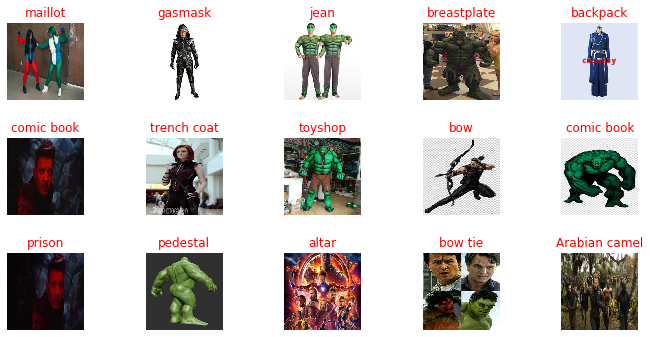

In [29]:
plot_images(image_batch, labels_batch, predicted_class_names)

## Downloading headless model

In [0]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=IMAGE_SIZE+(3,))

In [0]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 2048)


In [0]:
feature_extractor_layer.trainable = False

## Adding a classification head

In [0]:
model = Sequential([
  feature_extractor_layer,
  Dense(1024, activation='relu'),
  Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1025      
Total params: 25,664,001
Trainable params: 2,099,201
Non-trainable params: 23,564,800
_________________________________________________________________


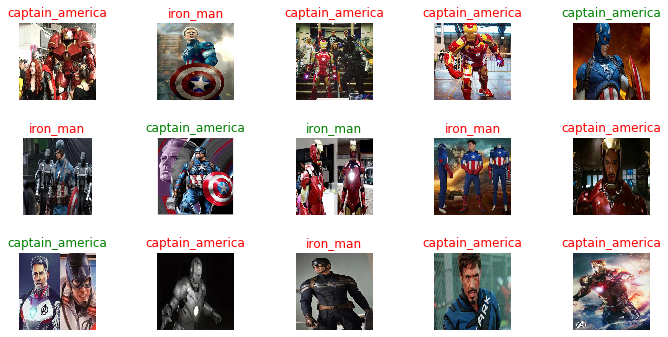

In [0]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()
plot_images(image_batch, labels_batch, predicted_class_names)

## Train the model

In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
history = model.fit(
    train_data_gen,
    epochs=5,
    steps_per_epoch=5,
    validation_data=val_data_gen
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 5 steps, validate for 4 steps
Epoch 1/5
5/5 [==============================] - 35s 7s/step - loss: 0.4544 - accuracy: 0.7703 - val_loss: 0.4685 - val_accuracy: 0.8400
Epoch 2/5
5/5 [==============================] - 32s 6s/step - loss: 0.2189 - accuracy: 0.9324 - val_loss: 0.3951 - val_accuracy: 0.8600
Epoch 3/5
5/5 [==============================] - 34s 7s/step - loss: 0.2779 - accuracy: 0.9062 - val_loss: 1.2356 - val_accuracy: 0.8100
Epoch 4/5
5/5 [==============================] - 34s 7s/step - loss: 0.2799 - accuracy: 0.9250 - val_loss: 0.4730 - val_accuracy: 0.7900
Epoch 5/5
5/5 [==============================] - 34s 7s/step - loss: 0.5814 - accuracy: 0.8562 - val_loss: 0.4683 - val_accuracy: 0.8600


## Check results

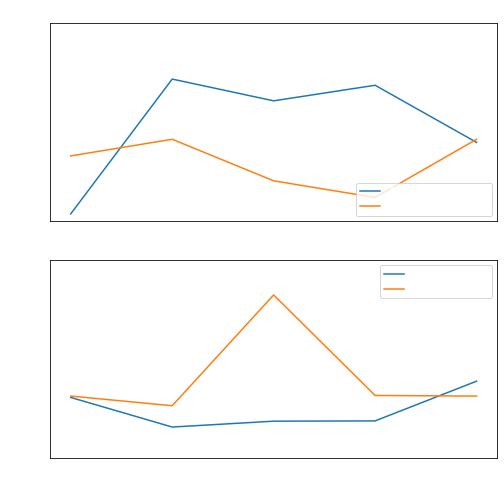

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.5])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

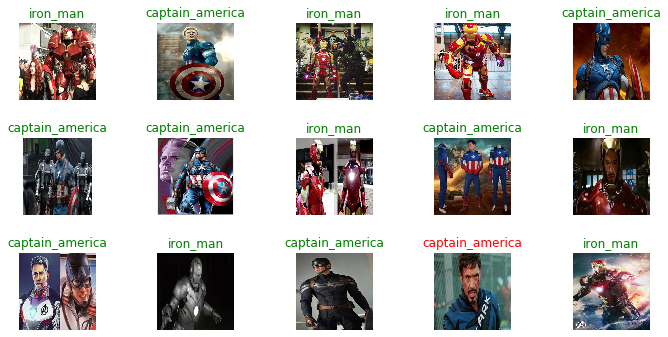

In [0]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()

plot_images(image_batch, labels_batch, predicted_class_names)

##Application base model

In [0]:
base_model = ResNet50V2(input_shape=IMAGE_SIZE+(3,),
                                               include_top=False,
                                               weights='imagenet')

In [0]:
base_model.trainable = False

In [0]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [0]:
model = Sequential([
  base_model,
  GlobalAveragePooling2D(),
  Dense(1024, activation='relu'),
  Dense(1, activation='sigmoid')    
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 25,664,001
Trainable params: 2,099,201
Non-trainable params: 23,564,800
_________________________________________________________________


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [0]:
history = model.fit(
    train_data_gen,
    epochs=5,
    steps_per_epoch=5,
    validation_data=val_data_gen
)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 5 steps, validate for 4 steps
Epoch 1/5
5/5 [==============================] - 41s 8s/step - loss: 0.4844 - accuracy: 0.7432 - val_loss: 1.2414 - val_accuracy: 0.7700
Epoch 2/5
5/5 [==============================] - 40s 8s/step - loss: 0.3538 - accuracy: 0.8687 - val_loss: 0.8648 - val_accuracy: 0.8100
Epoch 3/5
5/5 [==============================] - 40s 8s/step - loss: 0.1740 - accuracy: 0.9062 - val_loss: 1.0394 - val_accuracy: 0.8000
Epoch 4/5
5/5 [==============================] - 40s 8s/step - loss: 0.3776 - accuracy: 0.8500 - val_loss: 0.6914 - val_accuracy: 0.8500
Epoch 5/5
5/5 [==============================] - 40s 8s/step - loss: 0.2514 - accuracy: 0.9062 - val_loss: 0.8516 - val_accuracy: 0.8500


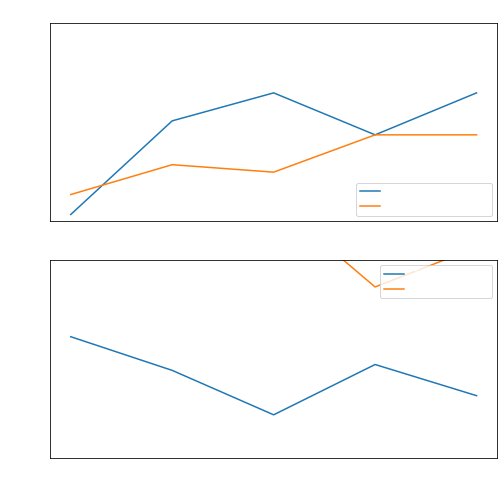

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,0.8])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()
plot_images(image_batch, labels_batch, predicted_class_names)

NameError: ignored

## Fine tuning

In [0]:
base_model.trainable = True

In [0]:
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 160
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False


Number of layers in the base model:  190


In [0]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1025      
Total params: 25,664,001
Trainable params: 16,542,721
Non-trainable params: 9,121,280
_________________________________________________________________


In [0]:
initial_epochs = 5
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_data_gen,
                         epochs=total_epochs,
                         steps_per_epoch=5,
                         initial_epoch =  history.epoch[-1],
                         validation_data=val_data_gen)

  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 5 steps, validate for 4 steps
Epoch 5/10
5/5 [==============================] - 52s 10s/step - loss: 0.8881 - accuracy: 0.7905 - val_loss: 24.5000 - val_accuracy: 0.5100
Epoch 6/10
5/5 [==============================] - 51s 10s/step - loss: 0.3730 - accuracy: 0.8625 - val_loss: 6.2740 - val_accuracy: 0.7900
Epoch 7/10
5/5 [==============================] - 53s 11s/step - loss: 0.2002 - accuracy: 0.9250 - val_loss: 58.8980 - val_accuracy: 0.5800
Epoch 8/10
5/5 [==============================] - 52s 10s/step - loss: 0.1746 - accuracy: 0.9688 - val_loss: 106.9501 - val_accuracy: 0.5400
Epoch 9/10
5/5 [==============================] - 52s 10s/step - loss: 0.1453 - accuracy: 0.9375 - val_loss: 113.7476 - val_accuracy: 0.5400
Epoch 10/10
5/5 [==============================] - 52s 10s/step - loss: 0.1827 - accuracy: 0.9187 - val_loss: 116.0304 - val_accuracy: 0.5400


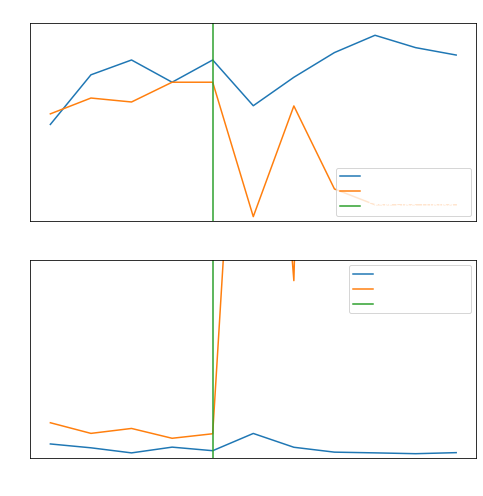

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 7.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

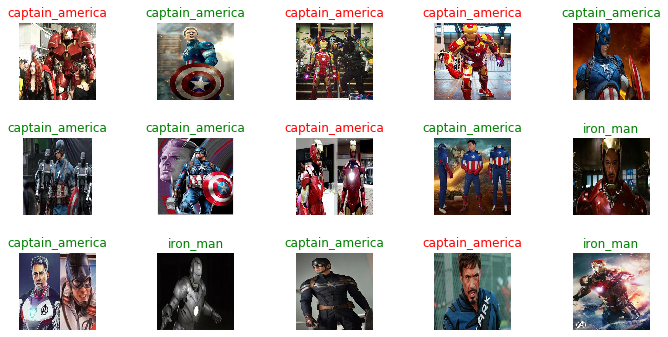

In [0]:
predictions = model(image_batch)
predicted_class_names = np.array(class_names)[np.rint(predictions).astype('int32')].flatten()
plot_images(image_batch, labels_batch, predicted_class_names)